In [142]:
## utils
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import math
from scipy.stats import pointbiserialr

sns.set_style('white')

## impute
from sklearn.impute import SimpleImputer

## one-hot encoding and scaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

## column transformer
from sklearn.compose import make_column_transformer

## pipeline
from sklearn.pipeline import make_pipeline

## train_test_split
from sklearn.model_selection import train_test_split

# Titanic Challenge
___

The main purpose of this challenge is to introduce users to their first classification problem. Using the data science process we will:

1. Business Understanding
   
2. Data Understanding

3. Data preparation

4. Modeling

5. Evaluation

6. Submition

#### Business Understanding
___

Hypothetical situation:

I was just hired for a data scientist job at a huge naval construction company. The company is called 'Iceberg' and they're going to make a real life functioning Titanic replica, my boss asked me to find the data from the original Titanic and usa machine learning to help him prepare for the worst. The main question was :

> "If our replica falls into the same situation as the original titanic, is there any way to predict who is going to survive?".

RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning hours of April 15, 1912 after striking an iceberg during her maiden voyage from Southampton to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making the sinking one of modern history's deadliest peacetime commercial marine disasters ... The final survivor of the sinking, Millvina Dean, aged two months at the time, died in 2009 at the age of 97 [1].

[1] https://en.wikipedia.org/wiki/RMS_Titanic

#### Reading the data
___

In [143]:
## reading the train and test data

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

#### Exploring the data
___

 - dependent variable : 'Survived'
 - indepent variables : 'PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'

In [144]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [145]:
train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

/home/nasserboan/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


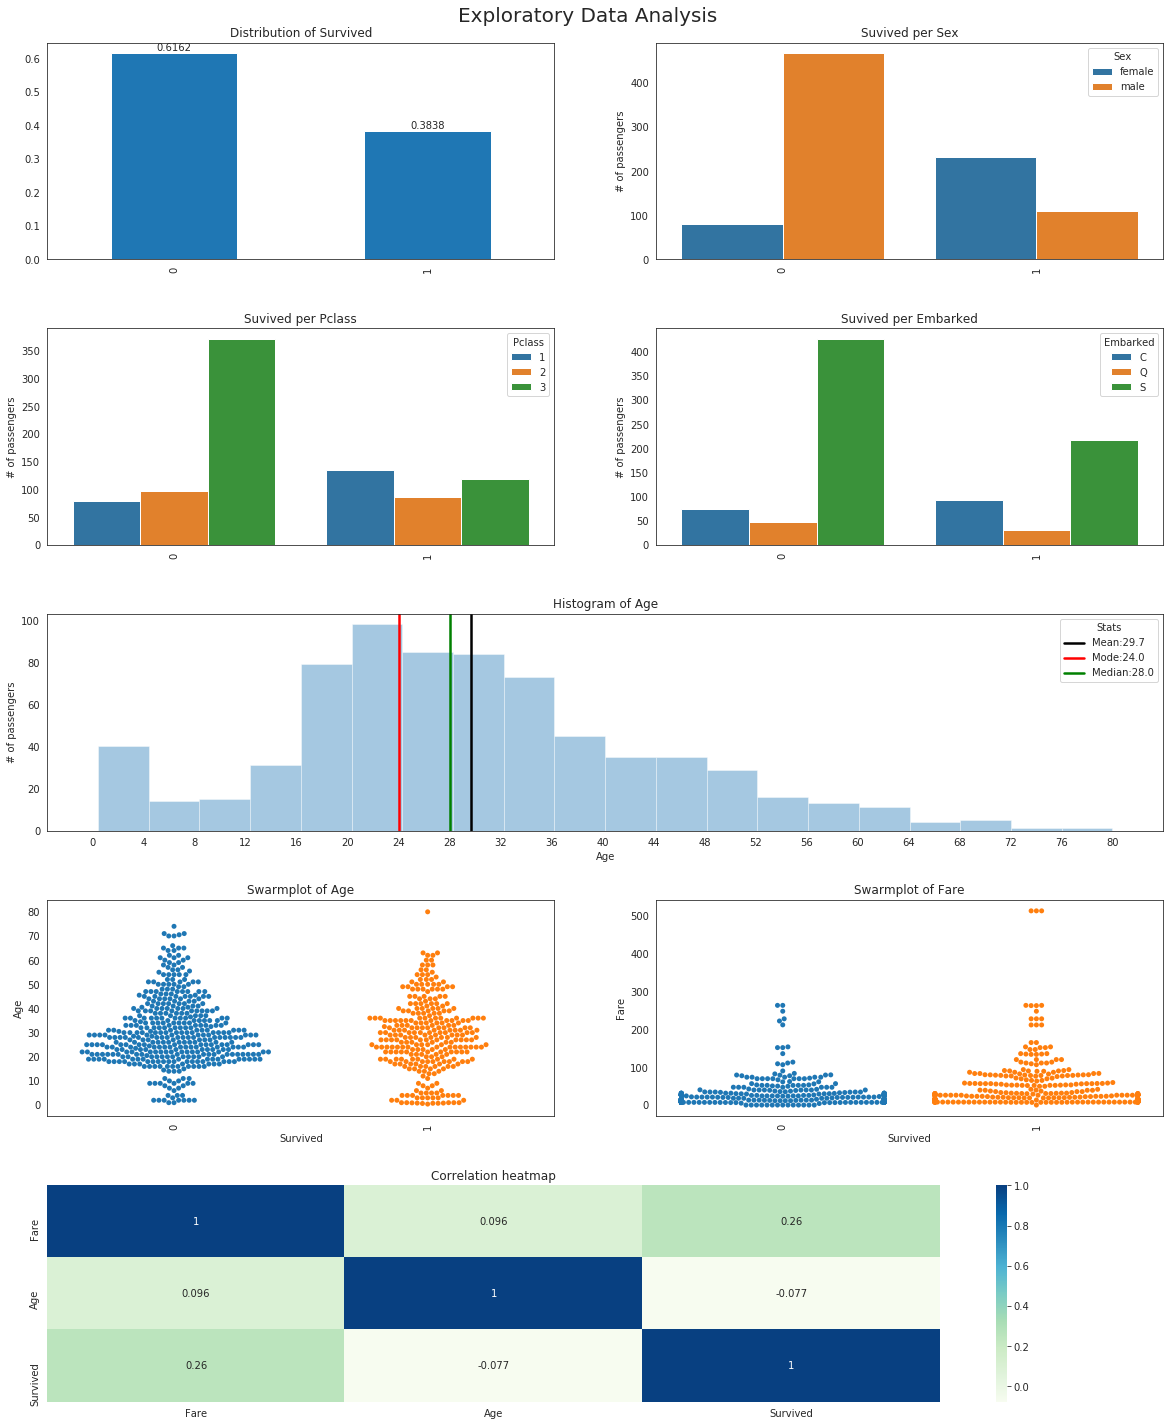

In [146]:
# defining the canvas and the subplots

fig = plt.figure(figsize=(20,25))
fig.suptitle('Exploratory Data Analysis',y=0.9,fontsize=20)
grid = plt.GridSpec(5,2, wspace= 0.2,hspace=0.32)

ax0 = plt.subplot(grid[0,0])
ax1 = plt.subplot(grid[0,1])
ax2 = plt.subplot(grid[1,0])
ax3 = plt.subplot(grid[1,1])
ax4 = plt.subplot(grid[2,:])
ax5 = plt.subplot(grid[3,0])
ax6 = plt.subplot(grid[3,1])
ax7 = plt.subplot(grid[4,:])



# distribution of survived
data = train.Survived.value_counts(normalize=True)
data.plot(kind='bar',ax=ax0)
ax0.set_title('Distribution of Survived')
ax0.text(x=-0.07,y=data[0]+0.008,s=f'{data[0]:.4f}')
ax0.text(x=0.93,y=data[1]+0.008,s=f'{data[1]:.4f}')



# dist survived per sex
data_sex = train[['PassengerId','Sex','Survived']].groupby(['Sex','Survived'],as_index=False).count()
sns.barplot(x='Survived',y='PassengerId',hue='Sex',data=data_sex,ax=ax1)
ax1.set_title('Suvived per Sex')
ax1.set_xticklabels(labels=ax1.get_xticklabels(),rotation='vertical')
ax1.set_xlabel('')
ax1.set_ylabel('# of passengers')



# histogram of ages
data_age = train[train['Age'].notna()].Age
data_age_mean = data_age.mean()
data_age_mode = statistics.mode(data_age)
data_age_median = data_age.median()
sns.distplot(data_age,ax=ax4,kde=False)

ax4.set_ylabel('# of passengers')
ax4.set_title('Histogram of Age')
ax4.axvline(data_age_mean,ls='-',lw=2.5,c='black')
ax4.axvline(data_age_mode,ls='-',lw=2.5,c='red')
ax4.axvline(data_age_median,ls='-',lw=2.5,c='green')
ax4.legend((f'Mean:{data_age_mean:.1f}',f'Mode:{data_age_mode:.1f}',f'Median:{data_age_median:.1f}'),title='Stats')
ax4.set_xticks(range(0,84,4))



# distribution of embarked
data_embarked = train[['PassengerId','Embarked','Survived']].groupby(['Embarked','Survived'],as_index=False).count()
sns.barplot(x='Survived',y='PassengerId',hue='Embarked',data=data_embarked,ax=ax3)
ax3.set_title('Suvived per Embarked')
ax3.set_xticklabels(labels=ax3.get_xticklabels(),rotation='vertical')
ax3.set_xlabel('')
ax3.set_ylabel('# of passengers');



# distribution of embarked
data_class = train[['PassengerId','Pclass','Survived']].groupby(['Pclass','Survived'],as_index=False).count()
sns.barplot(x='Survived',y='PassengerId',hue='Pclass',data=data_class,ax=ax2)
ax2.set_title('Suvived per Pclass')
ax2.set_xticklabels(labels=ax2.get_xticklabels(),rotation='vertical')
ax2.set_xlabel('')
ax2.set_ylabel('# of passengers');



# swarmplot of fare
sns.swarmplot(y=train.Fare,x=train.Survived,ax=ax6)
ax6.set_title('Swarmplot of Fare');
ax6.set_xticklabels(labels=ax6.get_xticklabels(),rotation='vertical')


# swarmplot of age
sns.swarmplot(y=train.Age,x=train.Survived,ax=ax5)
ax5.set_title('Swarmplot of Age');
ax5.set_xticklabels(labels=ax6.get_xticklabels(),rotation='vertical')


# heatmap correlation of Fare,Survived and Age
sns.heatmap(train[['Fare','Age','Survived']].corr(),cmap='GnBu',annot=True,ax=ax7)
ax7.set_title('Correlation heatmap');

In [147]:
## verifying the number of null values

train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Data preparation
___
- Deal with null values
- Remove unused columns
- Feature engineering
- Feature Scaling
- Feature Encoding
 
Strategy: define pipelines and functions to automate the model evaluation phase

In [148]:
def inputer_age(dataset):
    simple = SimpleImputer(missing_values=np.nan,strategy='mean')
    dataset['Age'] = simple.fit_transform(dataset[['Age']])
    return dataset

def inputer_embarked(dataset):
    simple = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
    dataset['Embarked'] = simple.fit_transform(dataset[['Embarked']])
    return dataset

def inputer_fare(dataset):
    simple = SimpleImputer(missing_values=np.nan,strategy='mean')
    dataset['Fare'] = simple.fit_transform(dataset[['Fare']])
    return dataset

def deal(dataset):
    dataset.drop(['Cabin','Ticket','PassengerId'],axis=1,inplace=True)
    inputer_age(dataset)
    inputer_embarked(dataset)
    inputer_fare(dataset)
    return dataset

In [149]:
train = deal(train)

In [150]:
train.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [152]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [153]:
def title(value):
    try:
        return re.search('Mr\.|Ms\.|Rev\.|Miss\.|Mrs\.|Don\.|Sir\.|Master\.|Dr\.|Mme\.|Capt\.|Col\.|Major\.|Countess\.|Lady\.|Mlle\.|Jonkheer\.',value).group(0)
    except:
        return print(f'Found : {value}')
    
def above_expectancy(value):
    if value > 54:
        return 1
    else:
        return 0

def time_of_life(df):
    df['time_of_life'] = pd.qcut(df['Age'],q=4,labels=['child','young','adult','senior'])
    
def family_size(df):
    df['family_size'] = df['SibSp'] + df['Parch']
    
def quantile_fare_cut(df):
    df['fare_cut'] = pd.qcut(df['Fare'],q=5,labels=['very low','low','medium','high','very high'])

def feature_engineering(dataset):
    dataset['Name'] = dataset['Name'].apply(title)
    dataset['above'] = dataset['Age'].apply(above_expectancy)
    time_of_life(dataset)
    family_size(dataset)
    quantile_fare_cut(dataset)
    return dataset

In [154]:
train = feature_engineering(train)

In [155]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,above,time_of_life,family_size,fare_cut
0,0,3,Mr.,male,22.0,1,0,7.2500,S,0,child,1,very low
1,1,1,Mrs.,female,38.0,1,0,71.2833,C,0,senior,1,very high
2,1,3,Miss.,female,26.0,0,0,7.9250,S,0,young,0,low
3,1,1,Mrs.,female,35.0,1,0,53.1000,S,0,adult,1,very high
4,0,3,Mr.,male,35.0,0,0,8.0500,S,0,adult,0,low


In [ ]:
## fazer scaling com make column transformer

In [66]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,above,time_of_life,family_size,fare_cut
0,1,0,3,Mr.,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,young,1,very low
1,2,1,1,Mrs.,female,38.0,1,0,PC 17599,71.2833,C85,C,0,adult,1,very high
2,3,1,3,Miss.,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,young,0,low
3,4,1,1,Mrs.,female,35.0,1,0,113803,53.1000,C123,S,0,adult,1,very high
4,5,0,3,Mr.,male,35.0,0,0,373450,8.0500,NaN,S,0,adult,0,low


In [41]:
## dealing with null values from Age
train['Age'] = train['Age'].fillna(train.Age.mean())

## dealing with null values from Embarked
train['Embarked'] = train.Embarked.fillna(statistics.mode(train.Embarked))

## droping the columns [Cabin,Ticket,PassengerId] they won't be used in this notebook
train.drop(['Cabin','Ticket','PassengerId'],axis=1,inplace=True)

In [42]:
## verifying the number of null values AGAIN

train.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [7]:
y = train.Survived
x = train.Fare

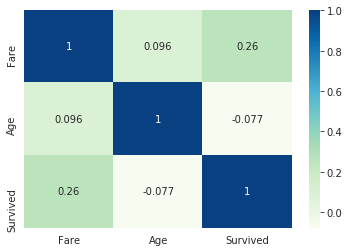

In [117]:
pointbiserialr(train.Fare,train.Survived)

PointbiserialrResult(correlation=0.2573065223849624, pvalue=6.120189341917992e-15)

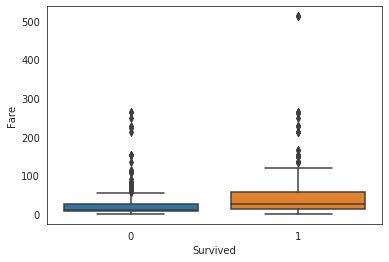

In [121]:
sns.boxplot(y=train.Fare,x=train.Survived)

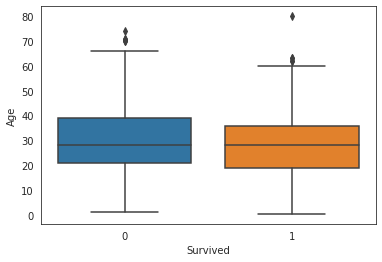

In [122]:
sns.boxplot(y=train.Age,x=train.Survived)

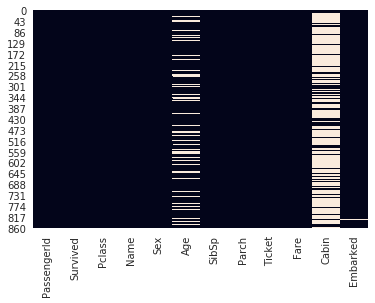

In [104]:
sns.heatmap(train.isna(),cbar=False)

In [334]:
((2/6)*math.log(2/6,2) + (4/6)*math.log(4/6,2))*-1

0.9182958340544896

In [339]:
((2/4)*math.log(2/4,2) + (2/4)*math.log(2/4,2))*-1

1.0

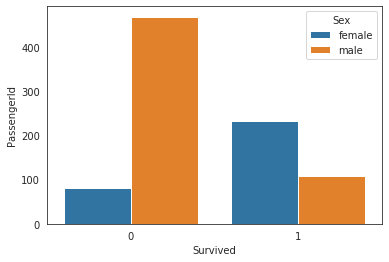

In [199]:
train[(train['Survived'] == 0) & (train['Sex'] == 'male')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S


In [138]:
data = train[['Sex','Survived','PassengerId']].groupby(['Sex','Survived'],as_index=False).count()
data

,Sex,Survived,PassengerId
0,female,0,81
1,female,1,233
2,male,0,468
3,male,1,109


In [ ]:
sns.barplot(x='Survived',y='PassengerId',hue='Sex')

In [137]:
def title(value):
    try:
        return re.search('Mr\.|Ms\.|Rev\.|Miss\.|Mrs\.|Don\.|Sir\.|Master\.|Dr\.|Mme\.|Capt\.|Col\.|Major\.|Countess\.|Lady\.|Mlle\.|Jonkheer\.',value).group(0)
    except:
        return print(f'Found : {value}')
    
def above_expectancy(value):
    if value > 54:
        return 1
    else:
        return 0

def time_of_life(df):
    df['time_of_life'] = pd.cut(df['Age'],bins=[0,13.5,27,40.5,54],labels=['child','young','adult','senior'])
    
def family_size(df):
    df['family_size'] = df['SibSp'] + df['Parch']
    
def quantile_fare_cut(df):
    df['fare_cut'] = pd.qcut(df['Fare'],q=5,labels=['very low','low','medium','high','very high'])

In [138]:
train['Age'] = train.Age.fillna(train.Age.mean())

0       very low
1      very high
2            low
3      very high
4            low
         ...    
886       medium
887         high
888         high
889         high
890     very low
Name: Fare, Length: 891, dtype: category
Categories (5, object): [very low < low < medium < high < very high]

In [87]:
train['title'] = train.Name.apply(title)

In [88]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


In [93]:
## life expectancy at UK 1911 - 54.3 fonte ('https://ourworldindata.org/life-expectancy')

train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [94]:
list(range(0,53))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52]

AttributeError: 'NoneType' object has no attribute 'group'

In [359]:
## verificando o tamanho dos dados

df.shape

(891, 12)

In [360]:
## verificando os tipos dos dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [361]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

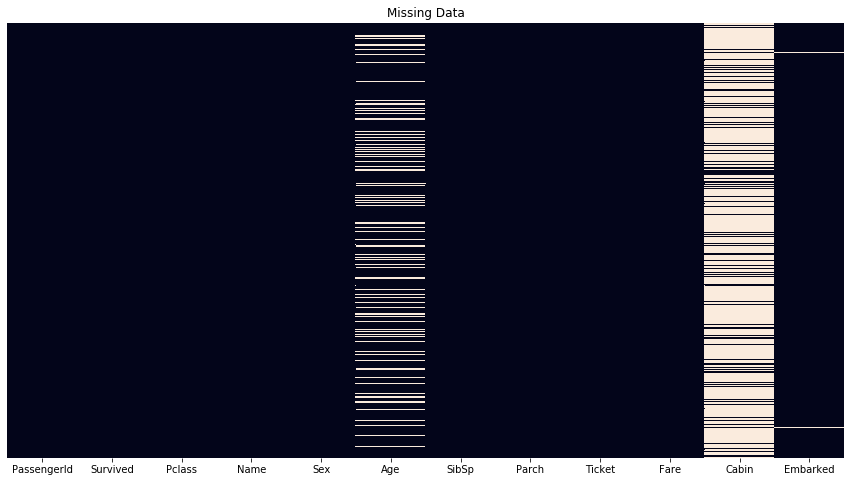

In [362]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(df.isna(),cbar=False);
ax.set_yticks([]);
ax.set_title('Missing Data');

In [363]:
df.isna().sum().map(lambda x: (x/len(df)*100))

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [364]:
df.dropna(subset=['Embarked'],inplace=True)
df.drop(['Cabin','PassengerId','Ticket'],axis=1,inplace=True)
df['Age'] = df['Age'].fillna(df.Age.mean())

In [365]:
cat = df[['Pclass','Sex','Embarked']]

In [366]:
one = OneHotEncoder(sparse=False)
cat_hot = one.fit_transform(cat)

In [367]:
cat_hot

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [368]:
cat_hot = pd.DataFrame(cat_hot,columns=one.get_feature_names())
cat_hot.head()

,x0_1,x0_2,x0_3,x1_female,x1_male,x2_C,x2_Q,x2_S
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [369]:
df = df.merge(cat_hot,how='left',on=df.index)

In [370]:
df.drop(['key_0','Pclass','Sex','Embarked','Name'],axis=1,inplace=True)

In [371]:
df.head()

,Survived,Age,SibSp,Parch,Fare,x0_1,x0_2,x0_3,x1_female,x1_male,x2_C,x2_Q,x2_S
0,0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [373]:
x = df.drop('Survived',axis=1)
y = df.Survived

In [374]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [375]:
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

/home/nzboan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [376]:
logreg.score(x_test,y_test)

0.850187265917603

In [377]:
from sklearn.model_selection import GridSearchCV

In [378]:
logreg = LogisticRegression()
params = {'penalty':['l1','l2'],'max_iter':[100,200,300,400],'solver':['warn','liblinear','saga']}


grid = GridSearchCV(logreg,param_grid=params,cv=5)
grid.fit(x,y)

/home/nzboan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nzboan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nzboan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nzboan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nzboan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_iter': [100, 200, 300, 400],
                         'penalty': ['l1', 'l2'],
                         'solver': ['warn', 'liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [379]:
grid.best_params_

{'max_iter': 100, 'penalty': 'l2', 'solver': 'warn'}

In [381]:
grid.best_score_

0.7941507311586051

## Baseline

In [176]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [179]:
df.shape

(889, 9)

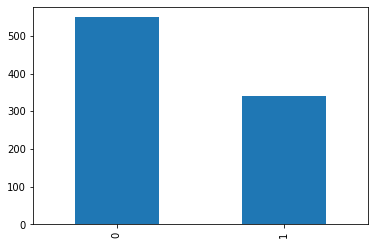

In [194]:
df.Survived.value_counts().plot(kind='bar')

In [183]:
df.Sex.value_counts()

male      577
female    312
Name: Sex, dtype: int64

In [193]:
df[df.Embarked == 'Q'].Survived.value_counts()

0    47
1    30
Name: Survived, dtype: int64

In [189]:
df.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [185]:
468/577

0.8110918544194108

In [186]:
81/312

0.25961538461538464

In [196]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [239]:
df['Age'] = df['Age'].fillna(df.Age.mean())

In [240]:
y = df.Survived

In [241]:
x = df.drop(['Survived','Name','Sex','Embarked'],axis=1)
x = x.values

In [242]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [243]:
from sklearn.linear_model import LogisticRegression

In [244]:
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

/home/nzboan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [245]:
logreg.coef_

array([[-0.68118691, -0.03672954, -0.22122903,  0.147783  ,  0.0089408 ]])

In [247]:
y_pred = logreg.predict(x_test)

In [255]:
logreg.score(x_test,y_test)

0.704119850187266

In [257]:
df.Survived.value_counts(normalize=True)

0    0.617548
1    0.382452
Name: Survived, dtype: float64

In [258]:
def modelo_nasser(dados):
    del dados
    return print('morreu')

In [91]:
def foo1(x):
    return x**2

In [92]:
foo = lambda x: x**2

In [96]:
ls1 = [1,2,3]

[x**2 for x in ls1]

[1, 4, 9]

In [95]:
for x in ls1:
    print(x)

1
2
3


In [97]:
df.Age

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 889, dtype: float64

In [106]:
from sklearn.linear_model import LinearRegression

In [147]:
a = df[['Age','Fare']].copy()
a.dropna(subset=['Age'],inplace=True)

In [148]:
x = a.Age.values.reshape(-1,1)
y = a.Fare.values

In [149]:
lr = LinearRegression()
lr.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [150]:
lr.intercept_

24.300901449288652

In [151]:
lr.coef_

array([0.34996368])

In [152]:
previsoes = lambda x: lr.intercept_ + (lr.coef_*x)

In [153]:
previsoes(22)

array([32.00010245])

In [87]:
impute_pipeline = make_pipeline(SimpleImputer())

make_column_transformer(
    (impute_pipeline,['Age']),
    (OneHotEncoder(),['Pclass','Sex','SibSp','Parch','Embarked']),
    (MinMaxScaler(),['Fare'])
                       )


TypeError: 'tuple' object is not callable

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [54]:
df[(df.Survived == 0) & (df.Sex == 'female')].Age.mean()

25.046875

In [181]:
df.groupby('Sex').count()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Sex,,,,,,,,,,,
female,314,314,314,314,261,314,314,314,314,97,312
male,577,577,577,577,453,577,577,577,577,107,577


In [182]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [50]:
109/577

0.18890814558058924

In [51]:
231/314

0.7356687898089171